# TP2: Modelado sobre dataset Fashion MNIST

## Librerías

Fuente: https://pjreddie.com/projects/mnist-in-csv/

In [1]:
import pandas as pd
import os
import gzip
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

Correr una sola vez para descargar toda la data luego mutear todo el chunk. 

In [2]:
# def download_gz_from_url(url, output_folder): 
#     file_name = url.split("/")[-1]
#     r = requests.get(url, stream=True)
#     with open(output_folder+"/"+file_name, 'wb') as f:
#         for chunk in r.raw.stream(1024, decode_content=False):
#             if chunk:
#                 f.write(chunk)

# output_folder= "./data"
                
# from pathlib import Path
# Path(output_folder).mkdir(parents=True, exist_ok=True)
                
# urls = ["http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz", #x_train
#         "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz", #y_train
#         "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz", #x_test
#         "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz" #y_test
#        ]
                
# for url in tqdm(urls):
#     download_gz_from_url(url,output_folder)

## Carga de Datos

In [2]:
import mnist_fashion_reader as mnist

X_train, y_train = mnist.load_mnist('data/', kind='train') #devuelve amigables objetos de Pandas
X_test, y_test = mnist.load_mnist('data/', kind='t10k') #devuevle amigables objetos de Pandas

## Punto 1: Exploración del dataset

Realizar una breve descripción del dataset. ¿Qué cantidad de datos tiene este conjunto? ¿Cuántos atributos? ¿Qué rangos de valores toman los atributos? ¿Qué cantidad de clases hay para clasificar? ¿Están balanceadas? Realizar un gráfico donde se muestran ejemplos de las clases (Puede ir a un anexo).

### Cantidad de datos del conjunto

In [4]:
df_entrenamiento = pd.concat([X_train.reset_index(drop=True), y_train], axis=1)
df_test = pd.concat([X_test.reset_index(drop=True), y_test], axis=1)
df_completo = pd.concat([df_entrenamiento, df_test])

In [5]:
print('Entrenamiento:', df_entrenamiento.shape,'  +  ' ,'Test:', df_test.shape, '  -->  ' , 'Completo:', df_completo.shape)

Entrenamiento: (60000, 785)   +   Test: (10000, 785)   -->   Completo: (70000, 785)


In [6]:
print(f"El dataset completo posee {len(df_completo)} registros. Cada registro corresponde a una imagen del dataset.")

El dataset completo posee 70000 registros. Cada registro corresponde a una imagen del dataset.


### Atributos

#### Cantidad de atributos

In [7]:
print(f"Cada atributo representa el valor de cada uno de los pixeles de cada imagen. Dado que cada imagen tiene un formato de 28 x 28 pixeles en escala de grises, el dataset posee {len(df_completo.columns)-1} atributos por registro, correspondientes al valor en escala de gris de cada pixel que compone la imagen")

print("+ UN (1) atributo con valores de 0 a 9 correspondiente a las clases a clasificar" )

Cada atributo representa el valor de cada uno de los pixeles de cada imagen. Dado que cada imagen tiene un formato de 28 x 28 pixeles en escala de grises, el dataset posee 784 atributos por registro, correspondientes al valor en escala de gris de cada pixel que compone la imagen
+ UN (1) atributo con valores de 0 a 9 correspondiente a las clases a clasificar


#### Rangos de valores

In [8]:
max_val = df_completo.max().max()
min_val = df_completo.min().min()

In [9]:
print(f"El valor mínimo de los atributos es {min_val} , y el máximo es {max_val}. Cada valor es un integer entre {min_val} y {max_val}")

El valor mínimo de los atributos es 0 , y el máximo es 255. Cada valor es un integer entre 0 y 255


#### Clases a clasificar

In [10]:
clases = np.sort(df_completo[0].unique())

clases

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [11]:
print(f"El dataset está compuesto por {len(clases)} clases")

El dataset está compuesto por 10 clases


##### N de clases

In [12]:
print(f"Las clases son: {clases}")

Las clases son: [0 1 2 3 4 5 6 7 8 9]


##### Balanceo de clases

In [13]:
Q = df_completo[0].value_counts().rename("Cant")
P = df_completo[0].value_counts(normalize=True).rename("%")

pd.concat([Q, P], axis=1).sort_index()


,Cant,%
0,7000,0.1
1,7000,0.1
2,7000,0.1
3,7000,0.1
4,7000,0.1
5,7000,0.1
6,7000,0.1
7,7000,0.1
8,7000,0.1
9,7000,0.1


##### Visualización 

## Separación en desarrollo y testeo

Separación de datos respetando la división presente en el github oficial de desarrollo y testeo

In [14]:
X_train.shape

(60000, 784)

In [15]:
y_train.shape

(60000,)

In [16]:
X_test.shape

(10000, 784)

In [17]:
y_test.shape

(10000,)

In [18]:
Q1 = y_train.value_counts().rename("Cant")
P1 = y_train.value_counts(normalize=True).rename("%")

pd.concat([Q1, P1], axis=1).sort_index().rename_axis('train')

,Cant,%
train,,
0,6000,0.1
1,6000,0.1
2,6000,0.1
3,6000,0.1
4,6000,0.1
5,6000,0.1
6,6000,0.1
7,6000,0.1
8,6000,0.1


In [19]:
Q2 = y_test.value_counts().rename("Cant")
P2 = y_test.value_counts(normalize=True).rename("%")

pd.concat([Q2, P2], axis=1).sort_index().rename_axis('test')

,Cant,%
test,,
0,1000,0.1
1,1000,0.1
2,1000,0.1
3,1000,0.1
4,1000,0.1
5,1000,0.1
6,1000,0.1
7,1000,0.1
8,1000,0.1


## Separación del conjunto de desarrollo en entrenamiento y validación

Conjunto de entrenamiento (85.71%):
* x_train, y_train = 80% del conjunto de entrenamiento
* x_val, y_val = 20% del conjunto de entrenamiento

Conjunto de testing(14.29%)
* X_test, y_test = Conjunto held-out de testing

In [3]:
from sklearn.model_selection import train_test_split
seed = 42

x_train, x_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=seed, stratify = y_train) 

## Entrenamiento inicial de modelos

Entrenamiento de 4 modelos con sus hiperparámetros por defecto

In [90]:
#https://stackoverflow-com.translate.goog/questions/39685740/calculate-sklearn-roc-auc-score-for-multi-class?_x_tr_sl=es&_x_tr_tl=en&_x_tr_hl=es&_x_tr_pto=wapp
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

def classif_report(true_vals, pred_vals):
    n_class = y_val.nunique()
    sk_report = classification_report(true_vals, pred_vals, output_dict=True)
    reportA = pd.DataFrame(sk_report).stack().unstack(0).iloc[0:n_class] 
    reportA['roc_auc'] = [v for k,v in roc_auc_score_multiclass(true_vals, pred_vals, average = "macro").items()]
    acc_score = [sk_report['accuracy']]*5
    macro_avg = reportA.mean()
    weighted_avg = np.average(reportA, axis = 0, weights=reportA.support)
    reportB = pd.DataFrame({"accuracy":acc_score,
                            "macro_avg": macro_avg,
                            "weighted_avg":weighted_avg}).stack().unstack(0)
    report = pd.concat([reportA, reportB], axis=0)
                            
    return report

### Boosting

#### GradientBoostingClassifier

In [92]:
seed = 42

In [94]:
gbc = GradientBoostingClassifier(random_state = seed, verbose=1)
gbc.fit(x_train, y_train)
y_pred = gbc.predict(x_val)

print("Accuracy training : {:.3f}".format(gbc.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(gbc.score(x_val, y_val)))
classif_report(y_val, y_pred)

      Iter       Train Loss   Remaining Time 
         1           1.8519           66.54m
         2           1.6078           68.75m
         3           1.4292           68.18m
         4           1.2882           66.75m
         5           1.1791           65.91m
         6           1.0887           64.87m
         7           1.0126           64.13m
         8           0.9453           63.43m
         9           0.8882           62.62m
        10           0.8397           62.21m
        20           0.5629           54.83m
        30           0.4552           47.82m
        40           0.3994           40.88m
        50           0.3635           34.01m
        60           0.3375           27.26m
        70           0.3178           20.47m
        80           0.3014           13.67m
        90           0.2868            6.83m
       100           0.2743            0.00s
Accuracy training : 0.908
Accuracy val: 0.875


,precision,recall,f1-score,support,roc_auc
0,0.816867,0.847500,0.831902,1200.0000,0.913194
1,0.990638,0.970000,0.980211,1200.0000,0.984491
2,0.762175,0.782500,0.772204,1200.0000,0.877685
3,0.886870,0.895000,0.890917,1200.0000,0.941157
4,0.773570,0.800000,0.786563,1200.0000,0.886991
5,0.966302,0.955833,0.961039,1200.0000,0.976065
6,0.697993,0.637500,0.666376,1200.0000,0.803426
7,0.939669,0.947500,0.943568,1200.0000,0.970370
8,0.965087,0.967500,0.966292,1200.0000,0.981806
9,0.951667,0.951667,0.951667,1200.0000,0.973148


### Bagging

#### Random Forest Classifier

In [96]:
rf = RandomForestClassifier(random_state = seed, verbose=1, n_jobs=-1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)

print("Accuracy training : {:.3f}".format(rf.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(rf.score(x_val, y_val)))
classif_report(y_val, y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Accuracy training : 1.000


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy val: 0.883


,precision,recall,f1-score,support,roc_auc
0,0.833200,0.870000,0.851203,1200.000000,0.925324
1,0.993168,0.969167,0.981021,1200.000000,0.984213
2,0.772727,0.807500,0.789731,1200.000000,0.890556
3,0.880452,0.908333,0.894176,1200.000000,0.947315
4,0.772370,0.820000,0.795473,1200.000000,0.896574
5,0.964942,0.963333,0.964137,1200.000000,0.979722
6,0.750501,0.624167,0.681529,1200.000000,0.800556
7,0.939217,0.940000,0.939608,1200.000000,0.966620
8,0.963756,0.975000,0.969345,1200.000000,0.985463
9,0.949124,0.948333,0.948729,1200.000000,0.971343


#### Bagging decision trees

Alternativa al random forest

In [98]:
dt = DecisionTreeClassifier(random_state=seed)
bdt = BaggingClassifier(dt, random_state = seed, verbose=1, n_jobs=-1)

bdt.fit(x_train, y_train)
y_pred = bdt.predict(x_val)

print("Accuracy training : {:.3f}".format(bdt.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(bdt.score(x_val, y_val)))
classif_report(y_val, y_pred)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   34.6s remaining:  2.3min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   35.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.1s remaining:    4.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.3s finished


Accuracy training : 0.994


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


Accuracy val: 0.858


,precision,recall,f1-score,support,roc_auc
0,0.793638,0.852500,0.822017,1200.000000,0.913935
1,0.977368,0.971667,0.974509,1200.000000,0.984583
2,0.734148,0.800833,0.766042,1200.000000,0.884306
3,0.855870,0.880833,0.868172,1200.000000,0.932176
4,0.755328,0.738333,0.746734,1200.000000,0.855880
5,0.937811,0.942500,0.940150,1200.000000,0.967778
6,0.700201,0.580000,0.634458,1200.000000,0.776204
7,0.911837,0.930833,0.921237,1200.000000,0.960417
8,0.945724,0.958333,0.951987,1200.000000,0.976111
9,0.951724,0.920000,0.935593,1200.000000,0.957407


### Árbol de decisión

In [100]:
ad = DecisionTreeClassifier(random_state = seed)
ad.fit(x_train, y_train)
y_pred = ad.predict(x_val)

print("Accuracy training : {:.3f}".format(ad.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(ad.score(x_val, y_val)))
classif_report(y_val, y_pred)

Accuracy training : 1.000
Accuracy val: 0.797


,precision,recall,f1-score,support,roc_auc
0,0.741803,0.754167,0.747934,1200.000000,0.862500
1,0.936222,0.954167,0.945109,1200.000000,0.973472
2,0.659420,0.682500,0.670762,1200.000000,0.821667
3,0.825818,0.778333,0.801373,1200.000000,0.880046
4,0.672370,0.655000,0.663571,1200.000000,0.809769
5,0.905961,0.899167,0.902551,1200.000000,0.944398
6,0.547170,0.555833,0.551468,1200.000000,0.752361
7,0.879368,0.880833,0.880100,1200.000000,0.933704
8,0.913151,0.920000,0.916563,1200.000000,0.955139
9,0.897822,0.893333,0.895572,1200.000000,0.941019


### Naive Bayes

In [103]:
nb = MultinomialNB(alpha=1.0) #alpha = 1.0 es el default 
nb.fit(x_train, y_train)

y_pred = nb.predict(x_val)
print("Accuracy training : {:.3f}".format(nb.score(x_train, y_train)))
print("Accuracy val: {:.3f}".format(nb.score(x_val, y_val)))
classif_report(y_val, y_pred)

Accuracy training : 0.666
Accuracy val: 0.668


,precision,recall,f1-score,support,roc_auc
0,0.748617,0.789167,0.768357,1200.000000,0.879861
1,0.984404,0.894167,0.937118,1200.000000,0.946296
2,0.624021,0.597500,0.610473,1200.000000,0.778750
3,0.665416,0.886667,0.760272,1200.000000,0.918565
4,0.460134,0.630000,0.531833,1200.000000,0.773935
5,0.691176,0.156667,0.255435,1200.000000,0.574444
6,0.322414,0.155833,0.210112,1200.000000,0.559722
7,0.595329,0.913333,0.720816,1200.000000,0.922176
8,0.887198,0.825833,0.855416,1200.000000,0.907083
9,0.686981,0.826667,0.750378,1200.000000,0.892407


## Métricas relevantes para el problema en el conjunto de validación

### Métricas

### Justificación

## Exploración de modelo Random Forest

In [42]:
scores_rf = []

for i in range(50, 501, 50):   ## modificar el range si se quiere probar otra combinación de hiperparámetros
   if i == 0:
      n_estimators = i + 1
   else:
      n_estimators = i

   start = time.time()

   rf = RandomForestClassifier(random_state=42, n_estimators = n_estimators)
   rf.fit(x_train, y_train)

   stop = time.time()
   
   y_pred = rf.predict(x_val)

   dict_rf = {'n_estimators':n_estimators, 'training_acc':rf.score(x_train, y_train), 'test_acc':rf.score(x_val, y_val), 'time':stop-start}

   scores_rf.append(dict_rf)


Grafico las distintas métricas para cada valor de n_estimators

In [43]:
scores_rf_df = pd.DataFrame(scores_rf)

In [70]:
scores_rf_df

,n_estimators,training_acc,test_acc,time
0,1,0.913729,0.767417,0.927732
1,50,0.999979,0.879167,37.059496
2,100,1.000000,0.882583,71.845289
3,150,1.000000,0.884000,109.759025
4,200,1.000000,0.885250,148.527537
5,250,1.000000,0.884833,186.595012
6,300,1.000000,0.884750,212.503955
7,350,1.000000,0.885167,244.841744
8,400,1.000000,0.885167,279.605595
9,450,1.000000,0.885750,323.463038


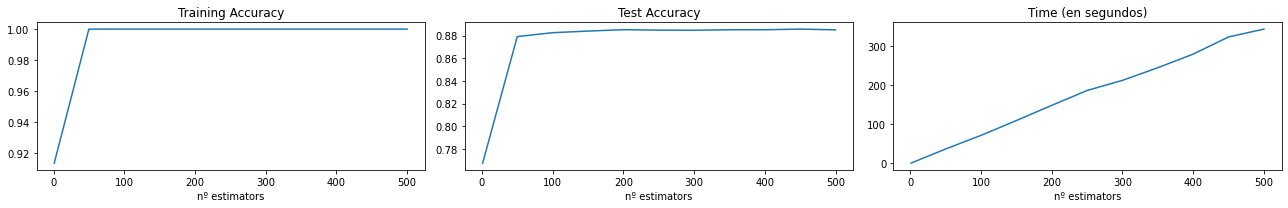

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(18,3))
axs[0].plot(scores_rf_df.n_estimators, scores_rf_df.training_acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel('nº estimators')
axs[1].plot(scores_rf_df.n_estimators, scores_rf_df.test_acc)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel('nº estimators')
axs[2].plot(scores_rf_df.n_estimators, scores_rf_df.time)
axs[2].set_title("Time (en segundos)")
axs[2].set_xlabel('nº estimators')
fig.tight_layout()

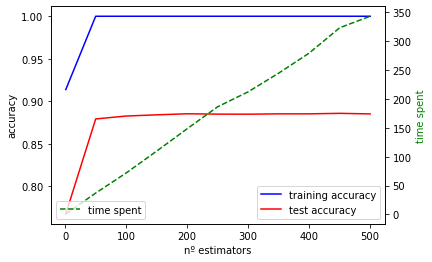

In [69]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(scores_rf_df.n_estimators, scores_rf_df.training_acc, 'b-', label = 'training accuracy')
ax1.plot(scores_rf_df.n_estimators, scores_rf_df.test_acc, 'r-', label = 'test accuracy')
ax2.plot(scores_rf_df.n_estimators, scores_rf_df.time, 'g--', label = 'time spent')

ax1.set_xlabel('nº estimators')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('time spent', color='g')
ax1.legend(loc="best")
ax2.legend(loc="lower left")

plt.show()

In [76]:
scores_rf_df.iloc[scores_rf_df.test_acc.argmax()]

n_estimators    450.000000
training_acc      1.000000
test_acc          0.885750
time            323.463038
Name: 9, dtype: float64

Fijando `n_estimators` $= 450$ se analiza variando `max_depth`

In [106]:
scores_rf = []
from tqdm import tqdm
for depth in tqdm(range(5, 101, 5)):   ## modificar el range si se quiere probar otra combinación de hiperparámetros
   
   start = time.time()

   rf = RandomForestClassifier(random_state=42, n_estimators = 450, max_depth=depth, n_jobs=-1)
   rf.fit(x_train, y_train)

   stop = time.time()
   
   y_pred = rf.predict(x_val)

   dict_rf = {'n_estimators':450,'max_depth':depth, 'training_acc':rf.score(x_train, y_train), 'test_acc':rf.score(x_val, y_val), 'time':stop-start}

   scores_rf.append(dict_rf)

  0%|                                                                                           | 0/20 [00:20<?, ?it/s]


NameError: name 'n_estimators' is not defined

## Exploración de modelo Gradient Boosting Machine

## Análisis de mejores modelos obtenidos de Random Forest y Gradient Boosting Machine

### Evaluación con conjunto de test

### Análisis de resultados en base a métricas elegidas

#### Análisis de métricas

### Conclusión sobre mejor modelo

### Matriz de confusión de mejor modelo

## Estabilidad del modelo frente al ruido